In [46]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv("data/train.csv", parse_dates=["DATETIME"]).set_index("DATETIME")["SOLAR PV"]
test = pd.read_csv("data/test.csv", parse_dates=["DATETIME"]).set_index("DATETIME")["SOLAR PV"]

<Axes: title={'center': 'Test Dataset'}, xlabel='DATETIME', ylabel='SOLAR PV (MW)'>

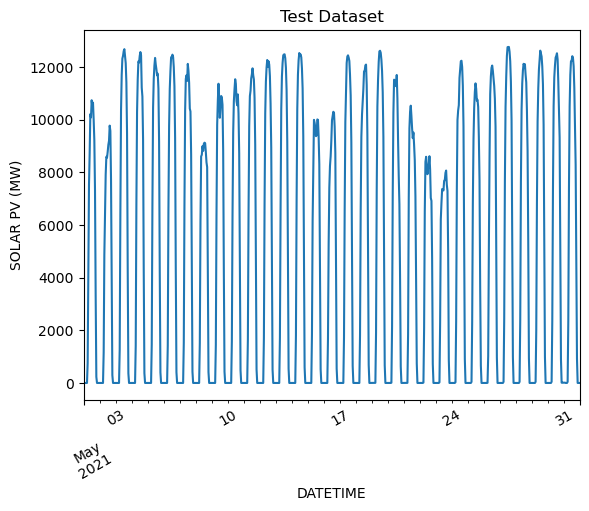

In [53]:
test.plot(ylabel="SOLAR PV (MW)", rot=30, title="Test Dataset")

<Axes: title={'center': 'Training Dataset'}, xlabel='DATETIME', ylabel='SOLAR PV (MW)'>

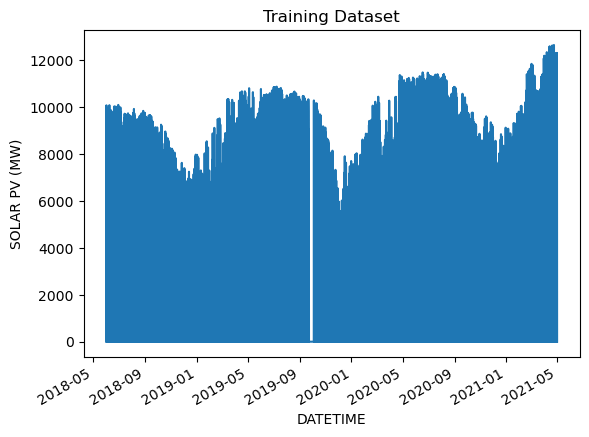

In [54]:
train.plot(ylabel="SOLAR PV (MW)", rot=30, title="Training Dataset")

<Axes: title={'center': 'hourly average over whole training set'}, xlabel='hour', ylabel='solar pv (mw)'>

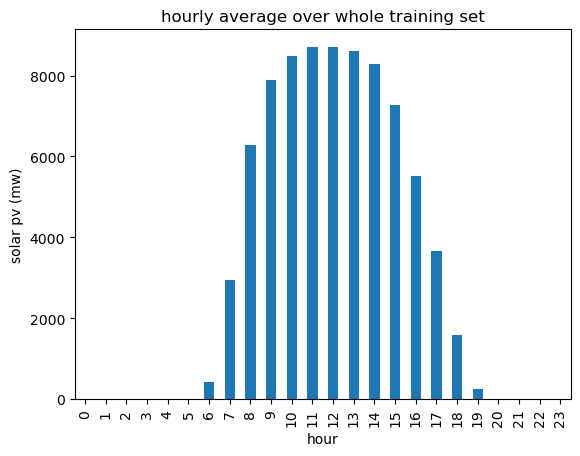

In [55]:
# so, what's a dumb model?  To start, let's just get a daily average.
time = train.index
pred_hourly = train.groupby(time.hour).mean()
pred_hourly.plot.bar(xlabel="hour", ylabel="solar pv (mw)", title="hourly average over whole training set")

In [37]:
# so now we can build our stupid baseline method
def baseline(train, pred_dt):
    hourly_average = train.groupby(train.index.hour).mean()
    pred = [hourly_average.loc[t.hour] for t in pred_dt]
    return pred

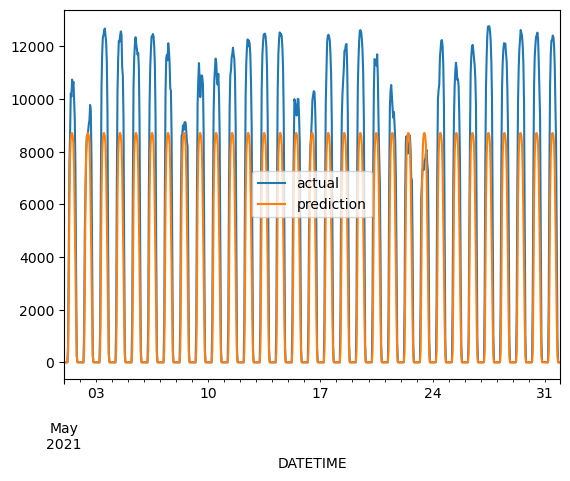

In [38]:
# plot the actual and the prediction
pred = baseline(train, test.index)
pred = pd.Series(pred, index=test.index)
ax = test.plot(label="actual")
pred.plot(ax=ax, label="prediction")
ax.legend()

MAE: 1725.30MW


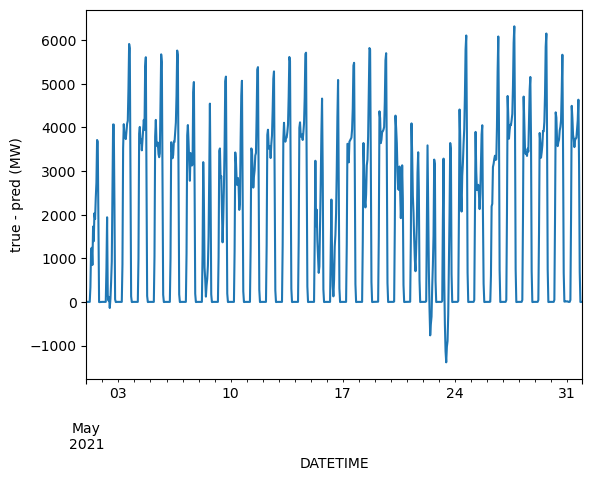

In [39]:
# and we can evaluate it, plot the residuals, and print the mae
from evaluate_method import evaluate
mae, residuals, pred = evaluate(baseline)

residuals.plot(ylabel="true - pred (MW)")
print(f"MAE: {mae:.2f}MW")

We can see that the above is a pretty bad model to predict the test set!  It consistently under-estimates.  That's because if you look at the plot of the training data, there's much more solar production in the summers than winters.  The test set is in summer, and our dumb baseline doesn't have any ability to account for this.  Also, it looks like production is increasing year-to-year.

We can make a simple modification to greatly improve this - only take into account the most recent training data - say, the last month.  Let's try that.

In [41]:
def baseline2(train, pred_dt):
    train_final_month = train[-30*24:]
    hourly_average = train_final_month.groupby(train_final_month.index.hour).mean()
    pred = [hourly_average.loc[t.hour] for t in pred_dt]
    return pred

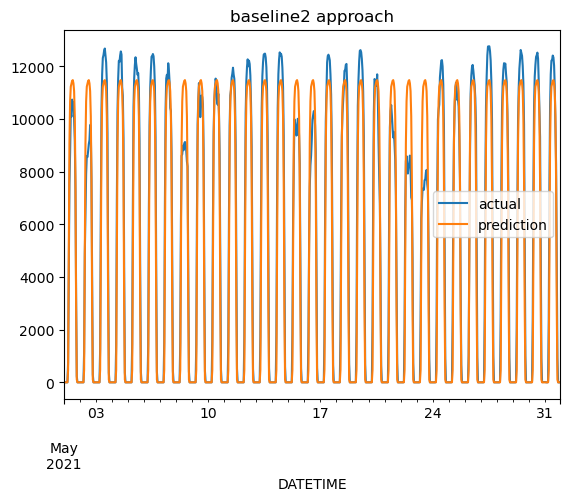

In [42]:
# plot the actual and the prediction
pred = baseline2(train, test.index)
pred = pd.Series(pred, index=test.index)
ax = test.plot(label="actual")
pred.plot(ax=ax, label="prediction", title="baseline2 approach")
ax.legend()

MAE: 686.72MW


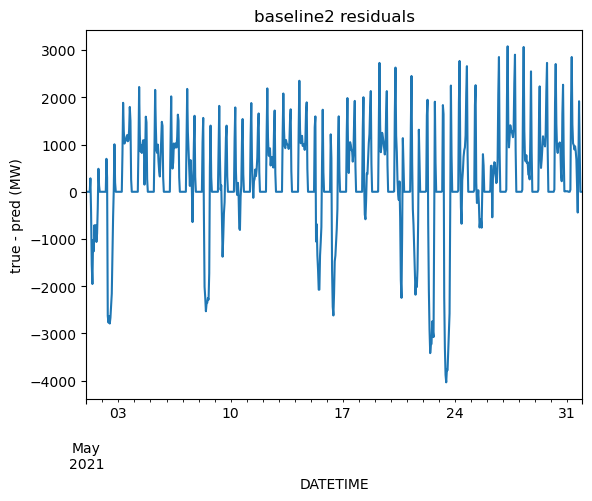

In [44]:
# and we can evaluate it, plot the residuals, and print the mae
from evaluate_method import evaluate
mae2, residuals2, pred2 = evaluate(baseline2)

residuals2.plot(ylabel="true - pred (MW)", title="baseline2 residuals")
print(f"MAE: {mae2:.2f}MW")

MAE: 725.34MW


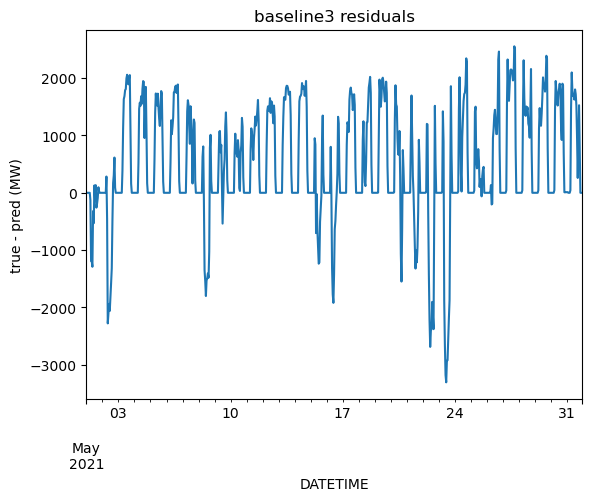

In [51]:
# hmm.  It still seems like our baseline is too low.  What if we use even more recent data?  Like only the previous week?
def baseline3(train, pred_dt):
    train_final_week = train[-7*24:]
    hourly_average = train_final_week.groupby(train_final_week.index.hour).mean()
    pred = [hourly_average.loc[t.hour] for t in pred_dt]
    return pred

mae3, residuals3, pred3 = evaluate(baseline3)

residuals3.plot(ylabel="true - pred (MW)", title="baseline3 residuals")
print(f"MAE: {mae3:.2f}MW")

Text(0.5, 1.0, 'MAE of baseline methods')

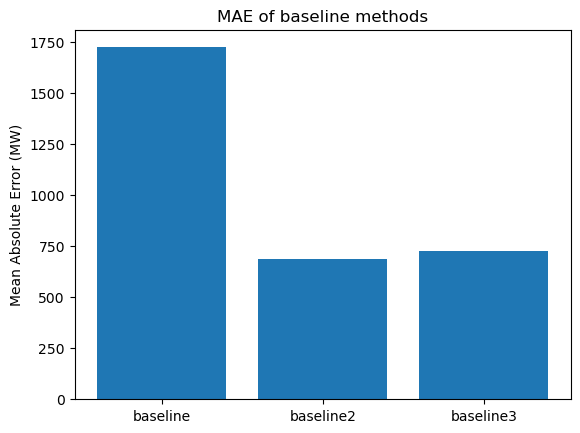

In [52]:
# and, we can compare the MAE of the two methods
plt.bar(["baseline", "baseline2", "baseline3"], [mae, mae2, mae3])
plt.ylabel("Mean Absolute Error (MW)")
plt.title("MAE of baseline methods")


Using hourly averages from the whole training dataset (baseline) doesn't do very well.  We can do much better by only considering the past month (baseline2).  However, when we use only the past week (baseline3), we don't see further improvement.  This is probably because we're hitting a tradeoff of recency and noise - the most recent week isn't a lot of data, and the averages could be highly influenced by transient events like weather.

Of course, these are baselines.  There must be a better way to capture the variability we observe.  It appears that there are several dependencies: seasonality affects both the daily max output, and the shape of the hourly curve throughout the day.  Then, there appears to be some sort of increase happening year-to-year, which could be linear, or more than linear.  If we build a simple periodic + linear model that combines these effects, perhaps a separate model for each hour of the day, then fit it to the training set, perhaps we will get a better projection for the test set.  Then, we can think about the more transient daily variations, by introducing another dataset that has cloud cover information for California.  These models will be more intelligent, and we will introduce them in another notebook.